# OpenMendel: Iterative Hard Thresholding Tutorial

### Last update: 10/15/2018

### When to use Iterative Hard Thresholding

*Continuous* model selection is advantageous in situations where the multivariate nature of the regressors plays a significant role *together*. Iterative hard-thresholing (IHT) performs continuous model selection on a GWAS dataset $\mathbf{X} \in \{0, 1, 2\}^{n \times p}$ and continuous phenotype vector $\mathbf{y}$ by minimizing the residual sum of squares $f(\beta) = \frac{1}{2}||\mathbf{y} - \mathbf{X}\beta||^2$ subject to the constraint that $\beta$ is $k-$sparse. Parallel computing is offered through `q-`fold cross validation, and in the near future, dense (genotype matrix)-(dense vector) multiplication. 

### Appropriate Datasets and Example Inputs 

All genotype data **must** be stored in the [PLINK binary genotype format](https://www.cog-genomics.org/plink2/formats#bed), where the triplets `.bim`, `.bed` and `.fam` must all be present. Additional non-genetic covariates should be stored in a separate file (e.g. comma separated file). In this tutorial, we use "gwas 1 data" (github repo: [here](https://github.com/OpenMendel/MendelGWAS.jl/tree/master/docs)) to illustrate the functionalities of MendelIHT. This dataset has 2200 people and a modest 10000 simulated SNPs, with 2 SNPs (`rs1935681` and `rs2256412`) contributing to the response. One can obtain this dataset from the first example input of [MendelGWAS.jl](https://openmendel.github.io/MendelGWAS.jl/), or via option 24a of the free application [Mendel version 16](http://www.genetics.ucla.edu/software/mendel). 


### Missing Data

`MendelIHT` assumes there are no missing genotypes, since it uses linear algebra functions defined in [SnpArrays.jl](https://openmendel.github.io/SnpArrays.jl/latest/man/snparray/#linear-algebra-with-snparray). Therefore, you must first impute missing genotypes before you use MendelIHT. SnpArrays.jl offer a naive imputation strategy, but otherwise, our own software [option 23 of Mendel](http://www.genetics.ucla.edu/software/mendel) is a reasonbale choice. Open Mendel will soon provide a separate package `MendelImpute` containing new imputation strategies such as alternating least squares.  

### Cross Validation and Regularization paths

We usually have very little information on how many SNPs are affecting the phenotype. In a typical GWAS study, anywhere between 1 to thousands of SNPs could play a role. Thus ideally, we can test many different models to find the best one. MendelIHT provides 2 ways for one to perform this automatically: user specified regulartization paths, and $q-$fold [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics). Users should know that, in the first method, increasing the number of predictors will almost always decrease the error, but as a result introduces overfitting. Therefore, in most practicaly situations, it is highly recommended to combine this method with cross validation. In $q-$fold cross validation, samples are divided into $q$ disjoint subsets, and IHT minimizes the MSE of a model fitted on $q-1$ of those sets data, then verifies the model on the $qth$ samples. Each $q$ subsets are served as the test set exactly once. As a result, cross validation typically finds a model with a good balance of error and overfitting.  

### Julia version

Current code supports Julia version 0.6. It will not work in v0.7 or v1.0, but upgrade to v1.0 is very high on our TODO list. 

### Analysis keywords available to users 

| Keyword | Default Value | Allowed value | Description |
| --- | --- | --- | --- |
|`predictors` | 0 | Positive integer | Max number of non-zero entries of $\beta$ |
|`non_genetic_covariates` | "" | File name on disk | Delimited file containing the non-genetic covariates for each sample |
|`run_specific_paths` | false | boolean | Whether user wants to run a lot of different model sizes $k$ |
|`model_size_paths` | "" | Integers stored in string separated by ',' | Different model sizes users wish to run IHT for |
|`max_groups` (\*) | 1 | Integer | Total number of groups |
|`group_membership` (\*) | "" | File name on disk | File indicating group membership |
|`prior_weights` (\*) | "" | maf | How to scale predictors based on different weights |
|`run_cross_validation` (\**) | false | boolean | Whether the user wants to run cross-validation |
|`cv_fold` (\**) | 0 | Positive integer | Number of folds cross-validation should run |

+ (\*) Indicates experimental features. We currently have no theoretical guarantees on their performance, therefore illustrations of these functionalities are omitted from this tutorial. Users should tread carefully with these features. 
+ (\**) Indicates features that will soon be available
+ A list of OpenMendel keywords common to most analysis package can be found [here](https://openmendel.github.io/MendelBase.jl/#keywords-table)

# Example 1: Run IHT with Only Genotype Data

### Step 1: Preparing Input files

In Open Mendel, all analysis parameters are specified via the [Control file](https://openmendel.github.io/MendelBase.jl/#control-file). Genotype data must be inputted via the PLINK binary format. The most basic control file to run IHT looks like the following:

In [17]:
;cat "gwas 1 Control basic.txt"

#
# Input and Output files.
#
plink_input_basename = gwas 1 data

#
# Analysis parameters for IHT option.
#
predictors = 2

### Step 2: Run MendelIHT

To run `MendelIHT`, execute the following in the Julia REPL or in this notebook:

In [2]:
using IHT
MendelIHT("gwas 1 Control basic.txt") # change directory as necessary

 
 
     Welcome to OpenMendel's
      IHT analysis option
        version 0.3.0
 
 
Reading the data.

The current working directory is "/Users/biona001/.julia/v0.6/IHT/test/MendelIHT_tutorial".

Keywords modified by the user:

  affected_designator = 2
  control_file = gwas 1 Control basic.txt
  pedigree_file = gwas 1 data.fam
  plink_input_basename = gwas 1 data
  predictors = 2
  snpdata_file = gwas 1 data.bed
  snpdefinition_file = gwas 1 data.bim
 


INFO: Reading in data
INFO: v1.0 BED file detected
INFO: Analyzing the data for model size k = 2


IHT results:

Compute time (sec):     1.939608051
Final loss:             1161.951128229144
Iterations:             12
Max number of groups:   1
Max predictors/group:   2
IHT estimated 2 nonzero coefficients.
2×3 DataFrames.DataFrame
│ Row │ Group │ Predictor │ Estimated_β │
├─────┼───────┼───────────┼─────────────┤
│ 1   │ 1     │ 3981      │ 0.149048    │
│ 2   │ 1     │ 7023      │ 0.272921    │

Intercept of model = 0.1405364595125695


### Step 3: Interpreting the results

Here the estimated model is the 3981th and 7023th predictor, corresponding to rs1935681 and rs2256412 in the `gwas 1 data.bim` file, which is the correct SNPs. The intercept of the model is given at the bottom of the table. Here the compute time is the time associated with computing the optimal $\beta$ only, so it does not include other necessary processes, such as importing the data. 

**Note:** the `affected_designator = 2` simply indicates that the pedigree is a Plink .fam file, which must always be the case for `MendelIHT` because this analysis option only accepts PLINK binary format as inputs. 

# Example 2: Including Non-Genetic Covariates

Non-genetic covariates must be stored in a comma demited file, with the same number of rows as the number of samples. The intercept term (i.e. grand mean) must also be included in the file. If the user does not specify a non-genetic covariate file, `MendelIHT` will by default include an intercept in the estimated model. 

### Step 1: Prepare Non-Genetic Covariate File

In this example, we generated one non-genetic covariate from a $N(0, 1)$ distribution. After including the grand mean, we saved the file in `gwas 1 noncov.txt` where the entries are separated by a tab. The first few lines of this file looks like the following:

In [16]:
;head -10 "gwas 1 noncov.txt"

1	-0.088704513339476
1	-0.9575873240069772
1	-0.9713258274139007
1	-0.9847900613424241
1	-0.5954781589540936
1	0.2124813875751884
1	2.28150775802523
1	1.7643235366779797
1	-0.3933262467789896
1	-0.1348394065324508


### Step 2: Prepare Corresponding Control File 

We need to tell MendelIHT that the covariates are separated by tabs. This can be achieved via the [MendelBase](https://openmendel.github.io/MendelBase.jl/) keyword `field_separator` as follows:

In [19]:
;cat "gwas 1 Control nongen.txt"

#
# Input and Output files.
#
plink_input_basename = gwas 1 data
non_genetic_covariates = gwas 1 noncov.txt
field_separator = '	'
#
# Analysis parameters for IHT option.
#
predictors = 2

### Step 3: Run IHT 

In [5]:
using IHT
MendelIHT("gwas 1 Control nongen.txt") # change directory as necessary

 
 
     Welcome to OpenMendel's
      IHT analysis option
        version 0.3.0
 
 
Reading the data.

The current working directory is "/Users/biona001/.julia/v0.6/IHT/test/MendelIHT_tutorial".

Keywords modified by the user:

  affected_designator = 2
  control_file = gwas 1 Control nongen.txt
  field_separator = 	
  non_genetic_covariates = gwas 1 noncov.txt
  pedigree_file = gwas 1 data.fam
  plink_input_basename = gwas 1 data
  predictors = 2
  snpdata_file = gwas 1 data.bed
  snpdefinition_file = gwas 1 data.bim
 


INFO: Reading in data
INFO: v1.0 BED file detected
INFO: Analyzing the data for model size k = 2


IHT results:

Compute time (sec):     1.579136089
Final loss:             1161.9471299575046
Iterations:             12
Max number of groups:   1
Max predictors/group:   2
IHT estimated 2 nonzero coefficients.
2×3 DataFrames.DataFrame
│ Row │ Group │ Predictor │ Estimated_β │
├─────┼───────┼───────────┼─────────────┤
│ 1   │ 1     │ 3981      │ 0.149032    │
│ 2   │ 1     │ 7023      │ 0.272937    │

Intercept of model = 0.14055574614433


**Remark:** Observe that the overall error did not change by much, and the estimated coefficients and intercept remained roughly the same. 

# Example 3: Specify Regularization Paths

In the first 2 examples, IHT was ran on simulated data where the true model size $(k = 2)$ was known. In this example, users can run IHT on any number of model in at most 8 parallel threads. Note that multithreading must be done in the terminal. Empirically, running on $n$ threads  achieves roughly $n/2$ fold speedup. 

### Step 1: Execute following line in terminal before starting notebook

In [6]:
export JULIA_NUM_THREADS=8

LoadError: [91msyntax: invalid assignment location "(export JULIA_NUM_THREADS)"[39m

### Step 2: Verify that notebook is indeed running with 8 threads:

In [7]:
Threads.nthreads()

8

### Step 3: Specify the model sizes

The paths should be inside quotes and separated by comma, specified via the keyword `model_sizes`. Each entry must be an integer. In this example, we tried to run IHT for model sizes $k = 1, 2, ..., 20$. The resulting model is stored in the sparse matrix, and both these models and the associated error is returned.

In [20]:
;cat "gwas 1 Control userpath.txt"

#
# Input and Output files.
#
plink_input_basename = gwas 1 data
#
# Analysis parameters for IHT option.
#
predictors = 2
model_sizes = "1,2,3,4,5,6,7,8,9,10"


### Step 4: Run the Control File (this step has ~10% chance of encountering thread safety issues. When error is thrown, simply run it again.)

In [6]:
using IHT
models, model_errors = MendelIHT("gwas 1 Control userpath.txt")

 
 
     Welcome to OpenMendel's
      IHT analysis option
        version 0.3.0
 
 
Reading the data.

The current working directory is "/Users/biona001/.julia/v0.6/IHT/test/MendelIHT_tutorial".

Keywords modified by the user:

  affected_designator = 2
  control_file = gwas 1 Control userpath.txt
  model_sizes = 1,2,3,4,5,6,7,8,9,10
  pedigree_file = gwas 1 data.fam
  plink_input_basename = gwas 1 data
  predictors = 2
  snpdata_file = gwas 1 data.bed
  snpdefinition_file = gwas 1 data.bim
 


INFO: Reading in data
INFO: v1.0 BED file detected
INFO: Running the following model sizes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


(
  [7023 ,     1]  =  0.276207
  [3981 ,     2]  =  0.149048
  [7023 ,     2]  =  0.272921
  [3981 ,     3]  =  0.151119
  [5793 ,     3]  =  -0.0856503
  [7023 ,     3]  =  0.272561
  [3981 ,     4]  =  0.146525
  [4398 ,     4]  =  0.0836463
  [6611 ,     4]  =  0.0840132
  [7023 ,     4]  =  0.270291
  ⋮
  [9467 ,     9]  =  -0.0832995
  [898  ,    10]  =  -0.0796667
  [1880 ,    10]  =  -0.0821465
  [2111 ,    10]  =  -0.08236
  [3981 ,    10]  =  0.144931
  [4398 ,    10]  =  0.0783766
  [5793 ,    10]  =  -0.0907393
  [6611 ,    10]  =  0.086168
  [6627 ,    10]  =  -0.0757259
  [7023 ,    10]  =  0.266956
  [9467 ,    10]  =  -0.0861502, [1186.37, 1161.95, 1153.89, 1146.47, 1137.96, 1131.32, 1124.64, 1118.68, 1111.06, 1103.63])

**Remark:** We can check that IHT is stable given different sparsity constraints, in the sense that parameters selected with a sparser constraint will still be selected if given a weaker constraint. Below we list the 10 models in separate columns.  

In [7]:
idx = find(models[:, end])
full(models[idx, :])

10×10 Array{Float64,2}:
 0.0       0.0        0.0        …  -0.0766181  -0.0782086  -0.0796667
 0.0       0.0        0.0           -0.077302   -0.0787067  -0.0821465
 0.0       0.0        0.0            0.0         0.0        -0.08236  
 0.0       0.149048   0.151119       0.144214    0.143389    0.144931 
 0.0       0.0        0.0            0.080625    0.0810577   0.0783766
 0.0       0.0       -0.0856503  …  -0.0869424  -0.0890821  -0.0907393
 0.0       0.0        0.0            0.0857555   0.0875377   0.086168 
 0.0       0.0        0.0           -0.0737263  -0.0751238  -0.0757259
 0.276207  0.272921   0.272561       0.264556    0.2656      0.266956 
 0.0       0.0        0.0            0.0        -0.0832995  -0.0861502

### Step 5: Observe the effect of overfitting

We fitted 20 different models with sizes ranging from 1 through 10. Recall that the true model size is $k = 2$, so the observed error reduction is a consequence of overfitting. We can plot them to visualize how they perform against each other:

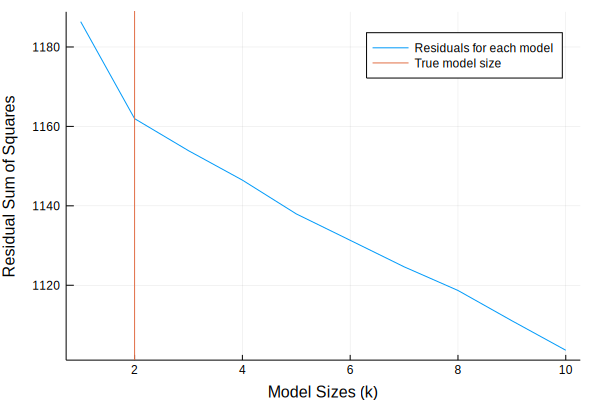

In [9]:
using Plots
x = collect(1:10) # model sizes
plot(x, model_errors,    
   yaxis="Residual Sum of Squares", 
   xaxis = "Model Sizes (k)", label = "Residuals for each model")
vline!([2], label = "True model size") # add line indicating the true model size

# Example 4: Cross Validation to Find Best Model Size

As the previous example shows, different choice of sparsity parameter $k$ can give you a model with smaller error. Therefore, finding a model size that simultaneously minimizes error and overfitting is paramount in applying IHT to real world datasets. In this example, we show how to run $q-$fold cross validation to achieve this.